In [18]:
# Step 1: Data Cleaning and Preprocessing

import pandas as pd

# Load the data (adjust the file path as needed)
file_path = 'orders_discount_data.xlsx'
data = pd.read_excel(file_path)

# 1. Remove unnecessary columns
data_cleaned = data.drop(columns=['Unnamed: 0'], errors='ignore')

# 2. Convert date_of_order to datetime format
data_cleaned['date_of_order'] = pd.to_datetime(data_cleaned['date_of_order'], errors='coerce')

# 3. Check for missing values
missing_values = data_cleaned.isnull().sum()
print("Missing values per column:\n", missing_values)

# 4. Convert department_desc to categorical
data_cleaned['department_desc'] = data_cleaned['department_desc'].astype('category')

# Display the cleaned data
print("\nCleaned Data (First 5 rows):")
print(data_cleaned.head())


Missing values per column:
 product_number     0
department_desc    0
discount           0
date_of_order      1
orders             1
dtype: int64

Cleaned Data (First 5 rows):
  product_number department_desc  discount date_of_order  orders
0              0               0      0.00    2018-06-15     6.0
1              0               0     36.59    2018-01-07    12.0
2              0               0     36.59    2018-02-07    15.0
3              0               0     36.59    2018-03-07     6.0
4              0               0     36.59    2018-04-07    30.0


Summary Statistics:
            discount         orders
count  599424.000000  599423.000000
mean       16.232714      30.585898
std        19.817764      36.237445
min         0.000000       0.000000
25%         0.000000      15.000000
50%         6.670000      22.000000
75%        30.000000      33.000000
max        85.560000    2058.000000


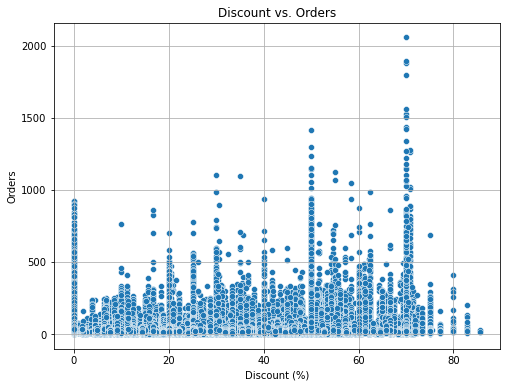

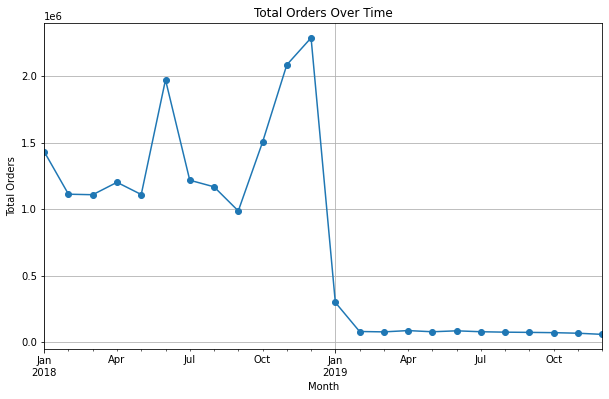

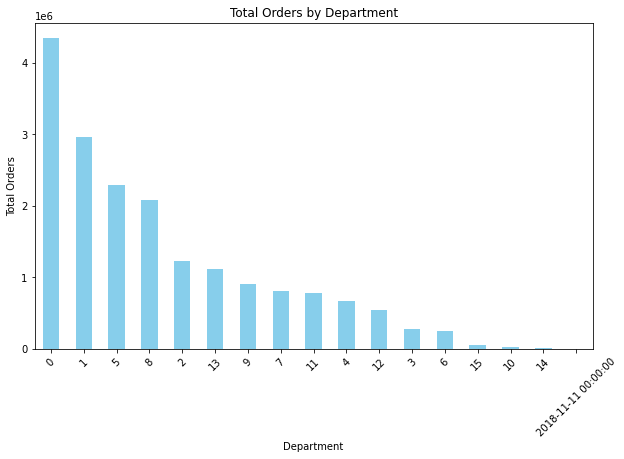

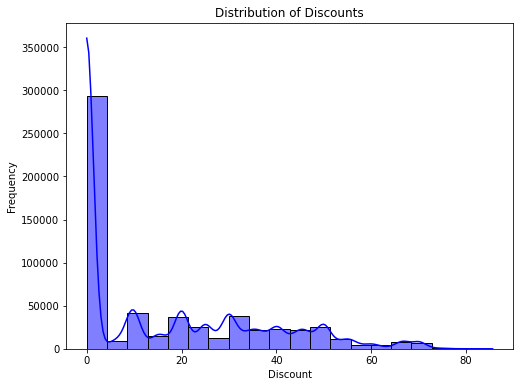

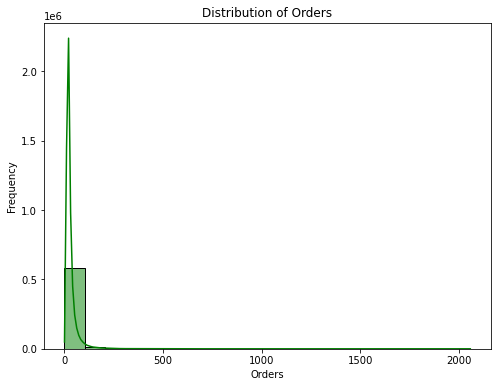

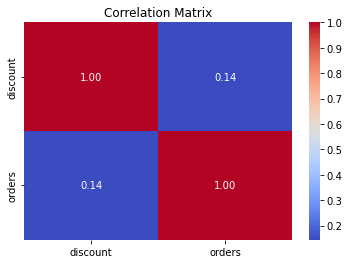

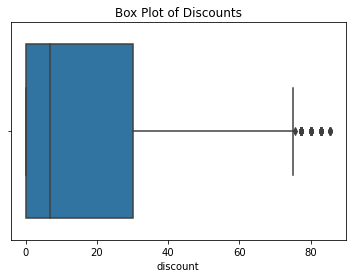

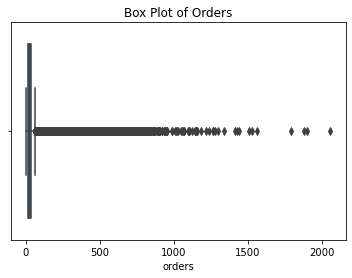

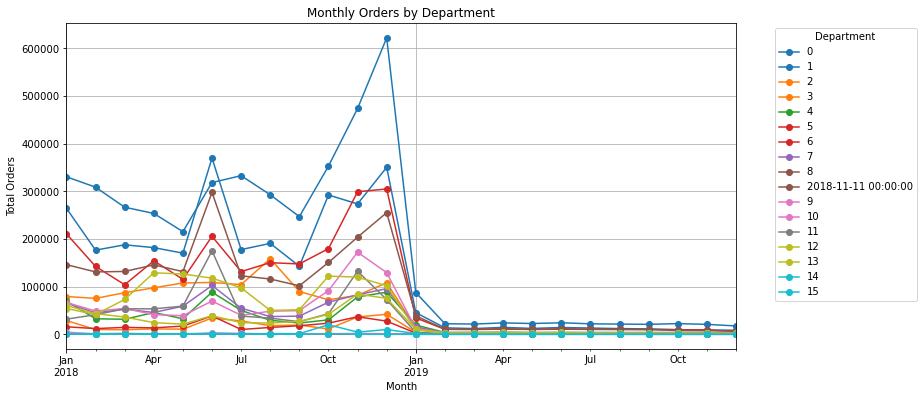

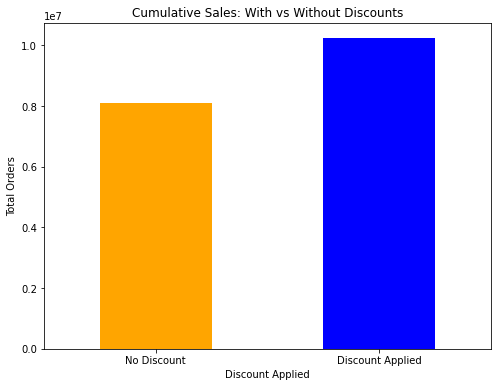

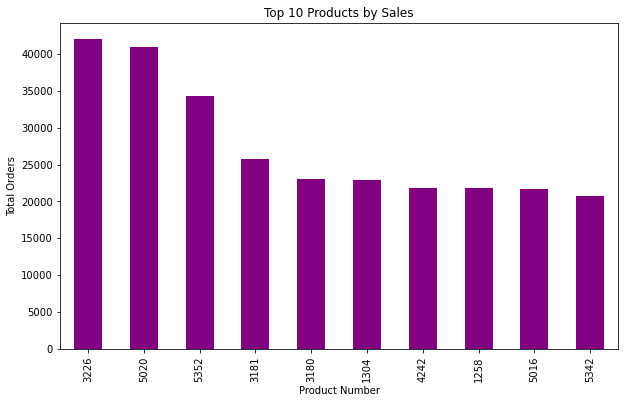

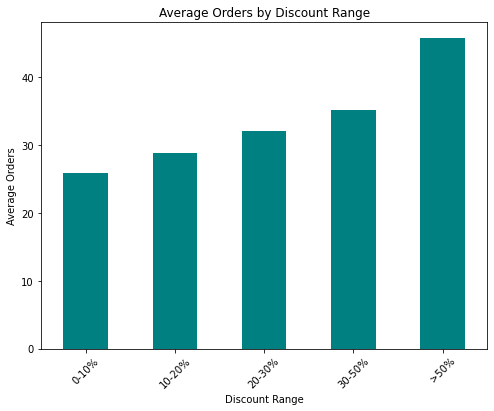

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `data_cleaned` is already available from Step 1

# 1. Summary Statistics
print("Summary Statistics:")
print(data_cleaned.describe())

# 2. Scatter Plot: Discount vs Orders
plt.figure(figsize=(8, 6))
sns.scatterplot(x='discount', y='orders', data=data_cleaned)
plt.title('Discount vs. Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Orders')
plt.grid(True)
plt.show()
#  It highlights how discounts contribute to sales but suggests there might be other factors influencing orders.

# 3. Trend Analysis: Orders Over Time
data_cleaned['month'] = data_cleaned['date_of_order'].dt.to_period('M')
orders_over_time = data_cleaned.groupby('month')['orders'].sum()

plt.figure(figsize=(10, 6))
orders_over_time.plot(kind='line', marker='o')
plt.title('Total Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.grid(True)
plt.show()
#This is accurate, but  should investigate why orders drop after January 2019 (e.g., missing data or seasonality)

# 4. Department-wise Discount Sensitivity
dept_analysis = data_cleaned.groupby('department_desc')['orders'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
dept_analysis.plot(kind='bar', color='skyblue')
plt.title('Total Orders by Department')
plt.xlabel('Department')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.show()

# 5. Distribution of Discounts and Orders
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['discount'], bins=20, kde=True, color='blue')
plt.title('Distribution of Discounts')
plt.xlabel('Discount')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned['orders'], bins=20, kde=True, color='green')
plt.title('Distribution of Orders')
plt.xlabel('Orders')
plt.ylabel('Frequency')
plt.show()

# 6. Correlation Analysis
correlation_matrix = data_cleaned[['discount', 'orders']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 7. Outlier Detection
plt.figure(figsize=(6, 4))
sns.boxplot(x=data_cleaned['discount'])
plt.title('Box Plot of Discounts')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=data_cleaned['orders'])
plt.title('Box Plot of Orders')
plt.show()

# 8. Time Series Analysis: Orders Over Time by Department
time_dept = data_cleaned.groupby(['month', 'department_desc'])['orders'].sum().unstack()

time_dept.plot(figsize=(12, 6), colormap='tab10', marker='o')
plt.title('Monthly Orders by Department')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 9. Cumulative Sales: With vs Without Discounts
data_cleaned['discount_applied'] = data_cleaned['discount'] > 0
cumulative_sales = data_cleaned.groupby('discount_applied')['orders'].sum()

cumulative_sales.plot(kind='bar', color=['orange', 'blue'], figsize=(8, 6))
plt.title('Cumulative Sales: With vs Without Discounts')
plt.xlabel('Discount Applied')
plt.ylabel('Total Orders')
plt.xticks([0, 1], ['No Discount', 'Discount Applied'], rotation=0)
plt.show()

# 10. Top Products Analysis
top_products = data_cleaned.groupby('product_number')['orders'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='purple')
plt.title('Top 10 Products by Sales')
plt.xlabel('Product Number')
plt.ylabel('Total Orders')
plt.show()

# 11. Effectiveness of Discounts: Average Orders by Discount Range
data_cleaned['discount_range'] = pd.cut(data_cleaned['discount'], bins=[0, 10, 20, 30, 50, 100],
                                        labels=['0-10%', '10-20%', '20-30%', '30-50%', '>50%'])
avg_orders_by_discount = data_cleaned.groupby('discount_range')['orders'].mean()

avg_orders_by_discount.plot(kind='bar', color='teal', figsize=(8, 6))
plt.title('Average Orders by Discount Range')
plt.xlabel('Discount Range')
plt.ylabel('Average Orders')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# 1. Calculate Elasticity
data_cleaned['pct_change_orders'] = data_cleaned['orders'].pct_change()
data_cleaned['pct_change_discount'] = data_cleaned['discount'].pct_change()

# Avoid division by zero
data_cleaned = data_cleaned.dropna(subset=['pct_change_orders', 'pct_change_discount'])
data_cleaned = data_cleaned[data_cleaned['pct_change_discount'] != 0]

data_cleaned['elasticity'] = data_cleaned['pct_change_orders'] / data_cleaned['pct_change_discount']

# Drop NaN or infinity values
data_cleaned['elasticity'] = data_cleaned['elasticity'].replace([np.inf, -np.inf], np.nan)
data_cleaned = data_cleaned.dropna(subset=['elasticity'])

# Average Elasticity
average_elasticity = data_cleaned['elasticity'].mean()
print(f"Average Price Elasticity of Demand: {average_elasticity}")

# Interpretation
if average_elasticity > 1:
    print("Demand is elastic: Customers are highly responsive to discounts.")
elif average_elasticity < 1:
    print("Demand is inelastic: Customers are less responsive to discounts.")
else:
    print("Demand has unit elasticity.")

# 2. Statistical Correlation
# 1. Calculate Pearson and Spearman Correlation
pearson_corr = data_cleaned['discount'].corr(data_cleaned['orders'], method='pearson')
spearman_corr = data_cleaned['discount'].corr(data_cleaned['orders'], method='spearman')

print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

# 2. Visualize with Scatter Plot and Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='discount', y='orders', data=data_cleaned, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Scatter Plot with Regression Line: Discount vs Orders')
plt.xlabel('Discount (%)')
plt.ylabel('Orders')
plt.grid(True)
plt.show()

# 3. Visualize Spearman Correlation with Rank Transform
data_cleaned['ranked_discount'] = data_cleaned['discount'].rank()
data_cleaned['ranked_orders'] = data_cleaned['orders'].rank()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='ranked_discount', y='ranked_orders', data=data_cleaned, alpha=0.3)
sns.regplot(x='ranked_discount', y='ranked_orders', data=data_cleaned, scatter=False, line_kws={'color': 'red'})
plt.title('Spearman Correlation: Ranked Discount vs Ranked Orders')
plt.xlabel('Ranked Discount')
plt.ylabel('Ranked Orders')
plt.grid(True)
plt.show()



# 3. Hypothesis Testing
# Split data into discounted and non-discounted groups
discounted = data_cleaned[data_cleaned['discount'] > 0]['orders']
non_discounted = data_cleaned[data_cleaned['discount'] == 0]['orders']

# Remove invalid rows
discounted = discounted[discounted > 0].dropna()
non_discounted = non_discounted[non_discounted > 0].dropna()

# Check data validity
print(f"Number of valid discounted rows: {len(discounted)}")
print(f"Number of valid non-discounted rows: {len(non_discounted)}")

# Ensure sufficient data points and variance
if len(discounted) < 2 or len(non_discounted) < 2:
    print("Insufficient data points for t-test in one or both groups.")
elif np.var(discounted) == 0 or np.var(non_discounted) == 0:
    print("One of the groups has no variance, making t-test invalid.")
else:
    # Perform t-test
    t_stat, p_value = ttest_ind(discounted, non_discounted, equal_var=False)
    print(f"T-statistic: {t_stat}, P-value: {p_value}")

    # Interpret the results
    if p_value < 0.05:
        print("Reject the null hypothesis: Discounts have a significant effect on sales.")
    else:
        print("Fail to reject the null hypothesis: Discounts do not have a significant effect on sales.")

Average Price Elasticity of Demand: 1.9185830440345129
Demand is elastic: Customers are highly responsive to discounts.
Pearson Correlation Coefficient: 0.23175055312555068
Spearman Correlation Coefficient: 0.21234024295950465
Number of valid discounted rows: 18529
Number of valid non-discounted rows: 6738
T-statistic: 26.441978873317257, P-value: 8.071057277111177e-152
Reject the null hypothesis: Discounts have a significant effect on sales.
